In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
#import squidpy as sq
import scanpy as sc
import pandas as pd
import os

from matplotlib import rcParams
import imagecodecs
import tifffile as tff
from pyometiff import OMETIFFReader
import seaborn as sns

import pickle
import ssam
import time
import anndata as ad

## Functions

In [2]:
# ===================================================
def read_ome_tiff(slide_type,data_dir,sample_dir):
    if slide_type=='focus':
        fn=os.path.join(data_dir,sample_dir,'morphology_focus.ome.tif')

    if slide_type=='mip':    
        fn=os.path.join(data_dir,sample_dir,'morphology_mip.ome.tif')

    if slide_type=='z_stack': 
        fn=os.path.join(data_dir,sample_dir,'morphology.ome.tif')
        
    reader = OMETIFFReader(fpath=fn)
    img_array,metadata,xml_metadata=reader.read()

    return img_array,metadata,xml_metadata

# ===================================================
def create_temp_output_dir(proc_dir,panel,sample_name):
    ## Create prcoessed data output directory if not existing yet
    if not os.path.isdir(proc_dir):
        os.makedirs(proc_dir)
        print(f'Created directory: {proc_dir}')
    
    ## Create output directory for sample if not existing yet
    sample_dirname='_'.join([panel.split('_')[-1],sample_name.split('__')[2]])
    sample_path=os.path.join(proc_dir,sample_dirname)

    if not os.path.isdir(sample_path):
        os.makedirs(sample_path)
        print(f'Created directory: {sample_path}')
    
    return sample_path

# ===================================================
## Setup function for calculating elapsed time
def print_elapsed_time(start,stop):
    # Calculate the elapsed time in seconds
    elapsed_seconds=stop-start
    
    # Convert elapsed time to hours and minutes
    elapsed_minutes, elapsed_seconds = divmod(int(elapsed_seconds), 60)
    elapsed_hours, elapsed_minutes = divmod(elapsed_minutes, 60)
    
    # Print the result in the desired format
    return(f"{elapsed_hours} hours: {elapsed_minutes} minutes: {elapsed_seconds} seconds")    


# ===================================================
def create_anndata_from_expr_vectors(ds,panel,sample_name):
    import anndata as ad
    expr_df=pd.DataFrame(data=ds.normalized_vectors,columns=ds.genes)

    # dataframe for annotating the observations
    obs=pd.DataFrame(index=expr_df.index)
    obs['sample_level_cluster']=ds.filtered_cluster_labels
    obs['sample_level_cluster']=obs['sample_level_cluster'].astype(str)
    obs['panel']=panel.split('_')[-1]
    obs['patient']=sample_name.split('__')[2].split('_')[0]
    obs['condition']=sample_name.split('__')[2].split('_')[1]
    obs['original_sample']=obs['panel']+'_'+obs['patient']+'_'+obs['condition']
    obs.index=[sample_name.split('__')[2].split('_')[0]+'_'+str(x) for x in np.arange(len(obs.index))]
    
    # Add spatial coordinates of local maxima (==estimated nuclei)
    obs['x']=ds.local_maxs[0]
    obs['y']=ds.local_maxs[1]
    obs['z']=ds.local_maxs[2]
    
    # dataframe for annotating the variables
    var=pd.DataFrame(index=expr_df.columns)

    # the data matrix 
    X=expr_df.values
    adata=ad.AnnData(X, obs=obs, var=var, dtype='float64')
    return adata    

## Load data into dict

In [3]:
data_dir="/Volumes/T7/Plaque_Xenium_data"
data_dir="/data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/"
proc_dir="/data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/processed_data/ssam_analysis"

## Drop scratch folders that start with "._"
panel_dir_list=[f for f in os.listdir(data_dir) if ('Panel' in f and '._' not in f)]
panel_dir_list.sort()

ds_dict={}
for panel in panel_dir_list[1:2]:
    panel_adata_list=[]
    panel_dir=os.path.join(data_dir,panel)
    sample_name_list=os.listdir(panel_dir)
    sample_name_list.sort()

    ## Loop over all samples in a batch
    for sample_name in sample_name_list[0:]:
        sample_dir=os.path.join(data_dir,panel,sample_name)
        
        if os.path.isdir(sample_dir) and 'P3_D' in sample_dir:

            slide_type='mip'
            img_array,metadata,xml_metadata=read_ome_tiff(slide_type,data_dir,sample_dir)
            #del img_array
            
            ### LOAD KDE ESTIMATED GENE EXPRESSION (SSAM DATASET OBJECT)
            print(sample_name)
            kde_tmp_output_dir=create_temp_output_dir(proc_dir,panel,sample_name)   
            pkl_fn=kde_tmp_output_dir+'/ds_filt.pickle'
            ds=pickle.load(open(pkl_fn, "rb"))
            ds_dict[panel.split('Sachs_')[-1]+'_'+sample_name.split('__')[2]]=ds

Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'
output-XETG00050__0003341__P3_D__20230817__135943


# Skimage  pictures, trying to determine cell boundaries

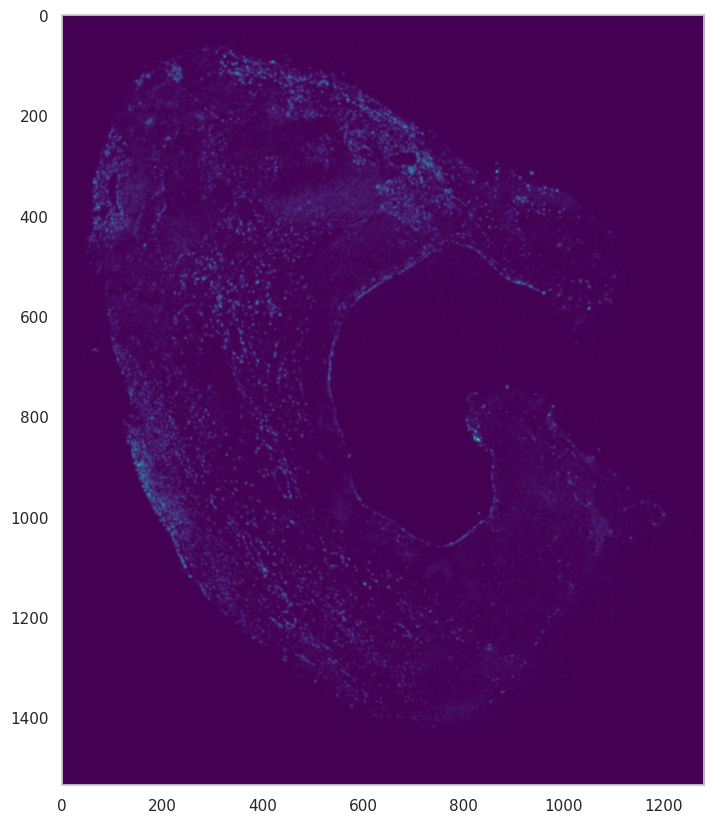

In [4]:
ds=ds_dict['Panel2_P3_D']

fig,ax=plt.subplots(1,1,figsize=(10,10))

b=(ds.vf_norm-ds.vf_norm.min())/(ds.vf_norm.max()-ds.vf_norm.min())
b=b.reshape(b.shape[0:2])
a=np.copy(b)
a[ds.local_maxs[0],ds.local_maxs[1]]=np.max(a)*1


#plt.imshow(ds.vf_norm[400:500,220:260])
#img=ax.imshow(a[1400:1800,400:800],cmap='viridis')
#img=ax.imshow(a[1000:2000,200:1200],cmap='viridis')
#img=ax.imshow(np.transpose(b)[800:1000,100:200],cmap='viridis')
img=ax.imshow(np.transpose(b),cmap='viridis')
#fig.colorbar(img,ax=ax)

#ax[1].scatter(ds.local_maxs[1][1600:1800],ds.local_maxs[0][600:800],s=1)
#ax[1].invert_yaxis()
#img2=ax[1].imshow(a[1600:1800,600:800])
#fig.colorbar(img2,ax=ax[1])



## Custom hessian function 

/tmp/ipykernel_299994/422594137.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')
/tmp/ipykernel_299994/422594137.py:30: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  img=ax[0].imshow(a[1400:1800,400:800],cmap='viridis')
/tmp/ipykernel_299994/422594137.py:41: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  img5=ax[1].imshow(aa[1400:1800,400:800],cmap=orig_map)
/tmp/ipykernel_299994/422594137.py:44: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  img6=ax[2].imshow(cc[1400:1800,400:800],cmap=orig_map)


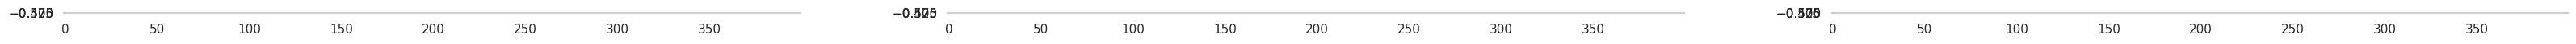

In [5]:
def hessian(x):
    """
    Calculate the hessian matrix with finite differences
    Parameters:
       - x : ndarray
    Returns:
       an array of shape (x.dim, x.ndim) + x.shape
       where the array[i, j, ...] corresponds to the second derivative x_ij
    """
    x_grad = np.gradient(x,0.5) 
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype=x.dtype) 
    for k, grad_k in enumerate(x_grad):
        # iterate over dimensions
        # apply gradient again to every component of the first derivative.
        tmp_grad = np.gradient(grad_k,0.5) 
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l,:,:] = grad_kl
    return hessian

hess=hessian(b)


# getting the original colormap using cm.get_cmap() function 
orig_map=plt.cm.get_cmap('viridis') 
  
# reversing the original colormap using reversed() function 
reversed_map = orig_map.reversed() 

fig,ax=plt.subplots(1,3,figsize=(40,25))
img=ax[0].imshow(a[1400:1800,400:800],cmap='viridis')
aa=np.copy(hess[0,1]+hess[0,0]+hess[1,1]+hess[1,0])*-1
#aa=np.copy(hess[1,1]+hess[1,0])*-1
aa[ds.local_maxs[0],ds.local_maxs[1]]=np.max(aa)*1.2
cc=np.copy(aa)
cc[np.logical_and(cc>-0.5,cc<0.5)]=-1

#img2=ax[1].imshow(hess[0,0,1400:1800,400:800],cmap='viridis')
#img3=ax[2].imshow(hess[0,1,1400:1800,400:800],cmap='viridis')
#img4=ax[1].imshow(hess[1,0,1400:1800,400:800],cmap='viridis')
#img5=ax[2].imshow(hess[1,1,1400:1800,400:800],cmap='viridis')
img5=ax[1].imshow(aa[1400:1800,400:800],cmap=orig_map)
#img=ax.imshow(b,cmap='viridis')
#fig.colorbar(img5,ax=ax[1])
img6=ax[2].imshow(cc[1400:1800,400:800],cmap=orig_map)
#fig.colorbar(img6,ax=ax[2])



## Rank.gradient 

In [7]:

from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage.morphology import disk,ball
from skimage.segmentation import watershed
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte

image=b[1400:1800,400:800]

# denoise image
denoised = image #rank.median(image, disk(2))

# find continuous region (low gradient -
# where less than 10 for this image) --> markers
# disk(5) is used here to get a more smooth image
markers = rank.gradient(denoised, disk(2)) >100
#markers = rank.otsu(denoised, disk(1))>30
#markers = ndi.label(markers)[0]

# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(denoised, disk(1))
gradient = rank.gradient(gradient, disk(1))

# process the watershed
labels = watershed(gradient, markers)

# display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax1=ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral)
ax[1].set_title("Local Gradient")
fig.colorbar(ax1,ax=ax[1])

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral)
ax[2].set_title("Markers")

ax[3].imshow(image, cmap=plt.cm.gray)
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
ax[3].set_title("Segmented")

for aaa in ax:
    aaa.axis('off')

fig.tight_layout()
plt.show()

ValueError: The parameter `image` cannot be an empty array

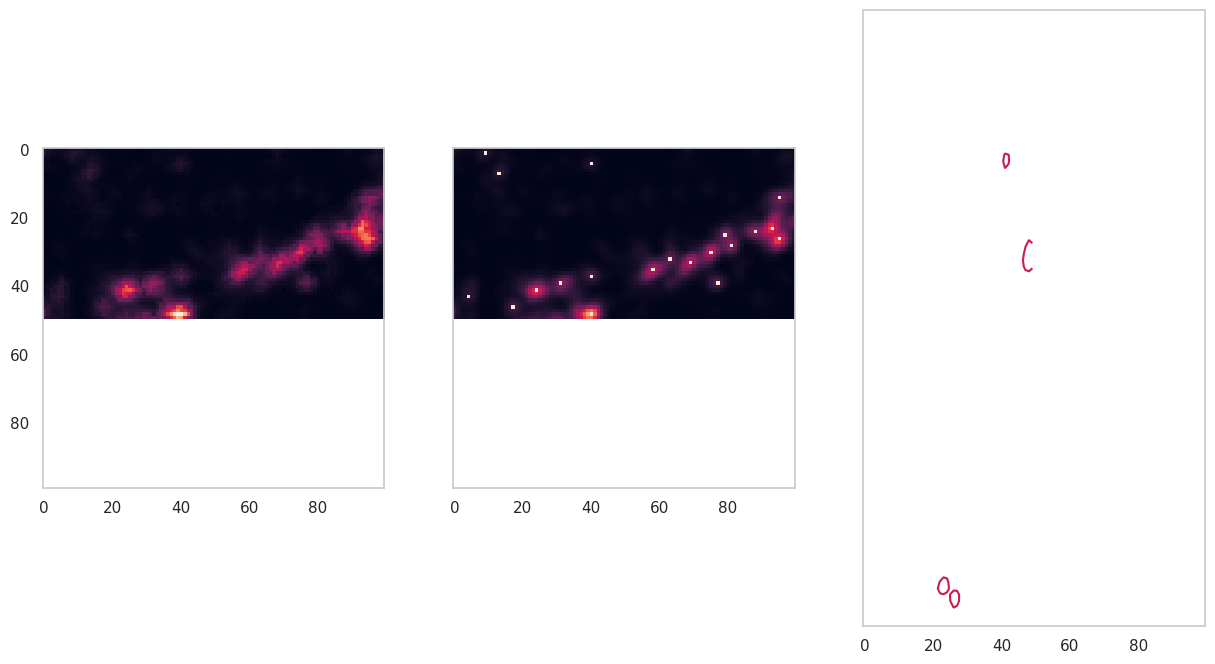

In [ ]:
from skimage.morphology import disk,diamond
from skimage.segmentation import flood, flood_fill
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8),
                         sharex=True, sharey=True)

img=a#[1400:1800,400:800]
img=b#[1400:1800,400:800]

gradient=rank.otsu(img, disk(1))
gradient2=rank.gradient(gradient, disk(1))
gradient_=np.copy(gradient)

#gradient_[ds.local_maxs[0],ds.local_maxs[1]]=np.max(gradient_)
#gradient2[ds.local_maxs[0],ds.local_maxs[1]]=np.max(gradient2)
#gradient_=skimage.segmentation.watershed(gradient_)
#for x,y in zip(ds.local_maxs[0],ds.local_maxs[1]):
    #gradient_=flood(image=gradient_, seed_point=(x,y), tolerance=0.01)

ax1=axes[0].imshow(gradient_[1650:1700,700:800])
#axes[1].hist(gradient_[1400:1800,400:800])
ax2=axes[1].imshow(a[1650:1700,700:800])
ax3=axes[2].contour((np.transpose(img[1650:1700,700:800])),levels=1)
#axes[2].invert_xaxis()
#axes[2].invert_yaxis()
#fig.colorbar(ax1,ax=axes[0])

## REsize original slide

In [8]:
from skimage.transform import rescale, resize
image_resized=resize(img_array, (b.shape[1], b.shape[0]),anti_aliasing=True)

In [ ]:
img_array.shape

(34061, 28425)

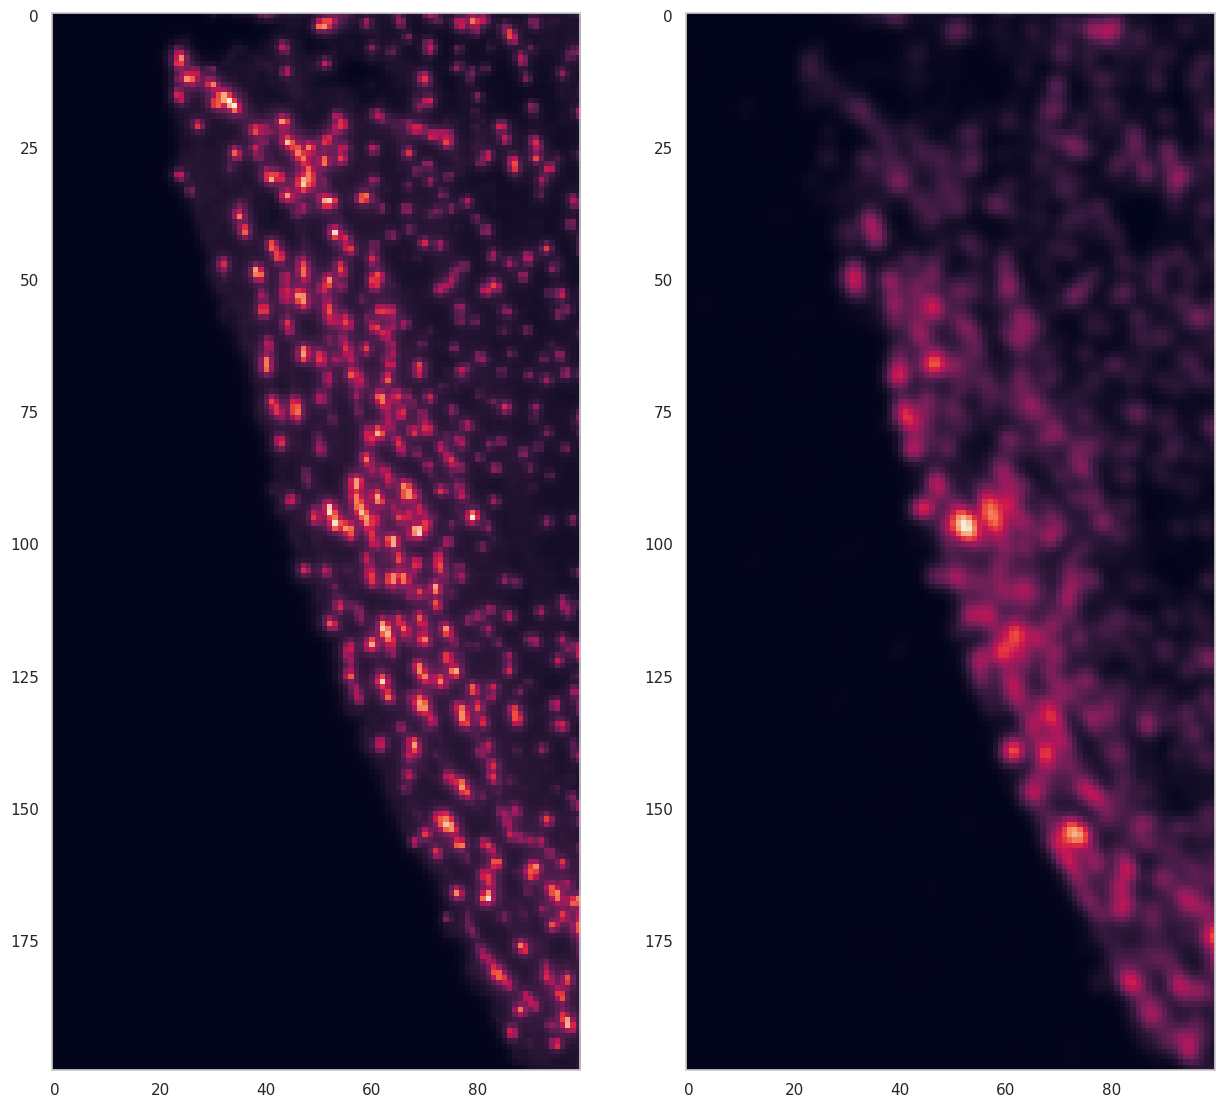

In [9]:
from sklearn.preprocessing import minmax_scale
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

def min_max_norm(x):
    norm=(x - np.min(x)) / (np.max(x) - np.min(x))
    return norm

image_arr=np.copy(min_max_norm(image_resized))



ax1=axes[0].imshow((image_resized)[800:1000,100:200])
#axes[0].invert_yaxis()
ax2=axes[1].imshow(min_max_norm(np.transpose(b))[800:1000,100:200])
#fig.colorbar(ax1,ax=axes[0])
#fig.colorbar(ax2,ax=axes[1])
plt.show()

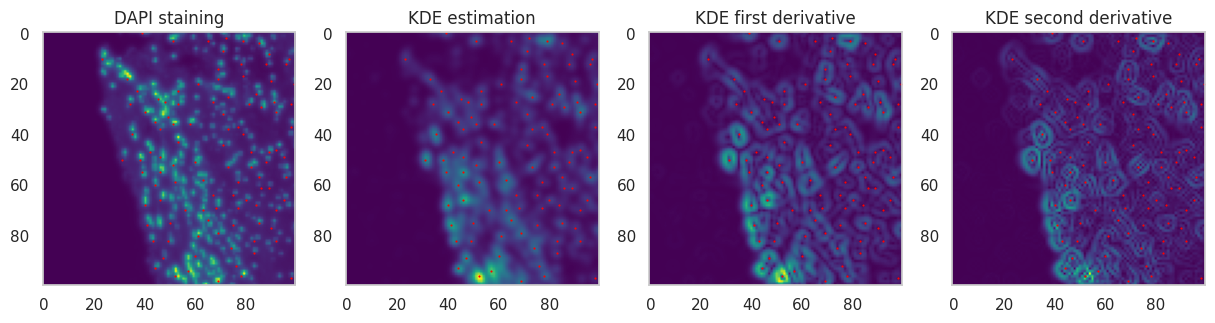

In [12]:
import numpy as np
from scipy import ndimage
from skimage import measure,filters
from skimage.segmentation import watershed,chan_vese,felzenszwalb,find_boundaries,inverse_gaussian_gradient
import matplotlib.pyplot as plt
from skimage.segmentation import flood, flood_fill

# Assuming you have a 2D kernel density estimation map named 'kde_map'
# and an array of local maximum points named 'local_max_points'

kde_map=np.copy(min_max_norm(np.transpose(b)[800:900,100:200]))
temp=np.copy(min_max_norm(np.transpose(a)[800:900,100:200]))
loc_max=np.where([temp==np.max(temp)])[1:]



# Generate markers for each local maximum point
markers = np.zeros_like(kde_map)
for i, (x, y) in enumerate(zip(loc_max[0],loc_max[1])):
    markers[x, y] = i + 1  # Mark each point with a unique label



# Apply watershed segmentation
mask=rank.gradient(kde_map, disk(1))
#mask=np.logical_and(rank.gradient(mask, disk(1))<100,rank.gradient(mask, disk(1))>0)
#mask=inverse_gaussian_gradient(kde_map, alpha=1, sigma=0.2)>0.0001


segmentation = watershed(-kde_map, markers, offset=[1,1], mask=mask)  # You may need to adjust the threshold

# Label connected components
labels, _ = ndimage.label(segmentation)

# Extract polygons for each cell
cell_polygons = []
for label in range(1, labels.max() + 1):
    mask = labels == label
    contours = measure.find_contours(mask, 1)  # You may need to adjust the contour level
    for contour in contours:
        cell_polygons.append(contour)



ff=inverse_gaussian_gradient(kde_map, alpha=1.0, sigma=0.2)
ff2=inverse_gaussian_gradient(ff, alpha=1.0, sigma=0.2)



# Plot the original image and the segmented cells
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow((image_resized[800:900,100:200]),cmap='viridis')
ax[0].scatter(loc_max[1], loc_max[0], c='red', marker='x',s=0.3)
ax[0].set_title('DAPI staining')

ax[1].imshow(kde_map, cmap='viridis')

ax[1].scatter(loc_max[1], loc_max[0], c='red', marker='x',s=0.3)
ax[1].set_title('KDE estimation')

ax[2].imshow(ff*-1, cmap='viridis')

ax[2].scatter(loc_max[1], loc_max[0], c='red', marker='x',s=0.3)
ax[2].set_title('KDE first derivative')
#ax[2].invert_yaxis()

ax[3].imshow((ff2*-1), cmap='viridis')
ax[3].scatter(loc_max[1], loc_max[0], c='red', marker='x',s=0.3)
ax[3].set_title('KDE second derivative')

plt.show()


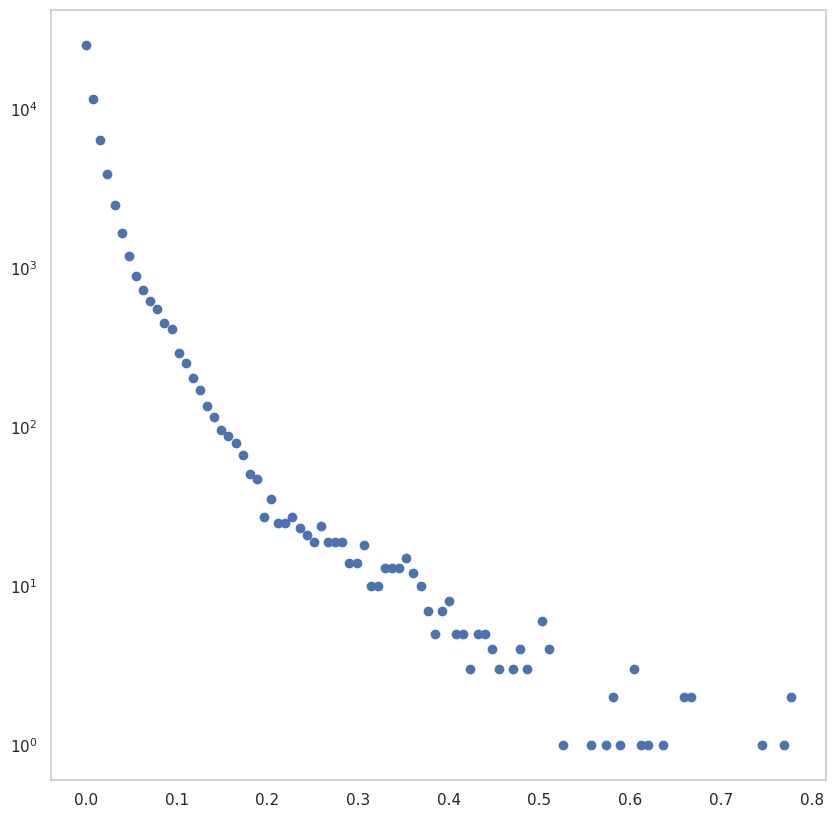

In [ ]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10, 10))
hist,bins=np.histogram(kde_map,bins=100)
ax.scatter(bins[:-1],hist)
ax.set_yscale('log')